# **Brain Abnormality Classification**



**Full name:**

**Student Number:**

In this exercise we are going to train a CNN-based model for a multi-class classification task, brain abnormality classification. The dataset we are going to use is a small imbalanced one that contains MRIs of both normal and abnormal brains.
We will learn how to use and refine models that have been already trained on some other rich datasets to deal with situations in which we don't have access to good datasets or powerful hardware.
This exercise has been broken into some smaller sections and each section has its score. What you are supposed to do is shown in `"======== TODO ========"` format. Any part which is showed by `...` should be completed. with There may be some **Questions** in the notes below. It is not necessary to answer these questions, but they will help you to do the next sections.

# Imports

First of all we need to import required libraries.

In [ ]:
from __future__ import print_function
from __future__ import division
import imgaug
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import matplotlib.pyplot as plt
import time
import shutil
import os
import random
import copy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.1+cu118
Torchvision Version:  0.15.2+cu118


# 1) Data Preparation:

## 1.1) Download Dataset

The following pieces of code will download dataset to your colab storage and remove corrupted or useless files.

In [ ]:
!wget --content-disposition https://figshare.com/ndownloader/files/28399209
!mkdir dataset
!tar xvf NINS_Dataset.tar --directory dataset/

In [ ]:
# Set the directory containing the images
data_dir = 'dataset/'

classes = os.listdir(data_dir)
shutil.rmtree(os.path.join(data_dir, 'models'))
classes = os.listdir(data_dir)

for c in classes:
    images = os.listdir(os.path.join(data_dir, c))
    for image in images:
      if image[-4:] != '.jpg':
        corrupted_img = os.path.join(data_dir, c, image)
        try:
          os.remove(corrupted_img)
        except:
          shutil.rmtree(corrupted_img)

## 1.2) Splitting Dataset: 5

The data should be spilitted into three groups: train, validation, and test. The groups' size are your choice and they should be reasonable, but it is recommended to use 0.8, 0.1, and 0.1 for train, validation, and test, respectively.

In [ ]:
# Set up directories and data splits
root_dir = 'dataset'
classes = os.listdir(root_dir)

############## To Do ##############
train_split = ...
val_split = ...
test_split = ...
###################################

# Create a dictionary with images and labels
data_dict = {}
for idx, class_name in enumerate(classes):
    class_dir = os.path.join(root_dir, class_name)
    data_dict[class_name] = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

############## To Do ##############
# Create train, validation and test splits
# Also print the number of samples in each class
train_images = []
val_images = []
test_images = []
for cls_name, images in data_dict.items():
    # your code ...
###################################

Stroke(infarct) : 906
Brain tumor (Dermoid cyst craniopharyngioma) : 38
meningioma : 76
small meningioma : 36
White Matter Disease : 36
Cerebral abscess : 36
Small Vessel Diease Demyelination : 38
Mid triventricular hydrocephalus : 38
Glioma : 76
pituitary tumor : 76
Microvascular ischemic change : 72
Brain Tumor (Hemangioblastoma  Pleomorphic xanthroastrocytoma  metastasis) : 74
Brain Infection with abscess : 76
Malformation (Chiari I) : 38
Brain tumor operated with ventricular hemorrhage : 76
Leukoencephalopathy with subcortical cysts : 38
Brain tumor - Recurrenceremnant of previous lesion : 114
focal pachymeningitis : 36
Stroke (Demyelination) : 38
Hemorrhagic collection : 38
Normal : 1749
Stroke (Haemorrhage) : 564
Ischemic change  demyelinating plaque : 38
Brain Tumor (Ependymoma) : 36
Obstructive Hydrocephalus : 76
cerebral venous sinus thrombosis : 76
Post-operative Status with Small Hemorrhage : 38
Postoperative encephalomalacia : 38
Brain tumor (Astrocytoma Ganglioglioma) : 38

**Question:** How many classes are there in your dataset?

**Question:** Did you notice the imbalance between classes?

We put samples of each group in a separate folder.

In [ ]:
!mkdir train val test

n_img = 0
for image in train_images:
  n_img += 1
  os.makedirs(os.path.join('train', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('train', *image.split('/')[1:]))

for image in val_images:
  os.makedirs(os.path.join('val', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('val', *image.split('/')[1:]))

for image in test_images:
  os.makedirs(os.path.join('test', image.split('/')[1]), exist_ok=True)
  shutil.copy(image, os.path.join('test', *image.split('/')[1:]))

## 1.3) Calculate Weights of Calsses: 5

As you saw there exists an imbalance between classes. The dataset contains a class with more than a thousand samples and classes with fewer than 50 samples.

Here we want to calculate coefficients (weights) that can compensate this gap. So you are supposed to calculate these coefficients for each class such that if you multiply a class size by its corresponding coefficient the result will be equal for all the other classes. The minimum value of a coefficient should be 1.

In [ ]:
############## To Do ##############
wgts = []

for c in classes:
  print(c)

  # Your code ...

  print('Size of Class: ' + ... )
  print('Weight of Class: ' + ... )
  print()

wgts = torch.Tensor(wgts)
###################################

Stroke(infarct)
Size of Class: 724
Weight of Class: 5.810773480662983

Brain tumor (Dermoid cyst craniopharyngioma)
Size of Class: 30
Weight of Class: 140.23333333333332

meningioma
Size of Class: 60
Weight of Class: 70.11666666666666

small meningioma
Size of Class: 28
Weight of Class: 150.25

White Matter Disease
Size of Class: 28
Weight of Class: 150.25

Cerebral abscess
Size of Class: 28
Weight of Class: 150.25

Small Vessel Diease Demyelination
Size of Class: 30
Weight of Class: 140.23333333333332

Mid triventricular hydrocephalus
Size of Class: 30
Weight of Class: 140.23333333333332

Glioma
Size of Class: 60
Weight of Class: 70.11666666666666

pituitary tumor
Size of Class: 60
Weight of Class: 70.11666666666666

Microvascular ischemic change
Size of Class: 57
Weight of Class: 73.80701754385964

Brain Tumor (Hemangioblastoma  Pleomorphic xanthroastrocytoma  metastasis)
Size of Class: 59
Weight of Class: 71.30508474576271

Brain Infection with abscess
Size of Class: 60
Weight of Cl

## 1.4) Create DataLoaders: 5

We read and put the data of each group in its corresponding list.

In [ ]:
train_images = []
train_aug_images = []
val_images = []
test_images = []

for c in classes:
    class_dir = os.path.join('train', c)
    train_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('val', c)
    val_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

    class_dir = os.path.join('test', c)
    test_images += [os.path.join(class_dir, img) for img in os.listdir(class_dir)]

Define required transforms and create Dataloaders.

**Question:** What is the approperiate input size of models like ResNet, VGG, etc.? Becarefull about the size of your images as well.

**Notice:** Select a suitable batch size.

**Notice:** Becarefull about the range of input values. They should be in [0, 1).

In [ ]:
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_list, classes=None, transform=None):
        self.image_list = image_list
        self.transform = transform
        self.label_encoder = {c: i for (i, c) in enumerate(classes)}

    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_list[index])
        
        if self.transform is not None:
            image = self.transform(image)
        
        label = self.image_list[index].split('/')[-2]
        label = self.label_encoder[label]

        return image, label


############## To Do ##############

# Define the transformations to be applied on the train and validation sets
transforms = transforms.Compose([
    ...
])

# Create datasets using defined CustomDataset class
train_dataset = ...
val_dataset = ...
test_dataset = ...

# Create dataloaders
train_loader = ...
val_loader = ...
test_loader = ...

###################################

In [ ]:
data_loaders = {'train': train_loader, 'val': val_loader}
num_cls = ... # Number of classes

## 1.2) Data Visualization

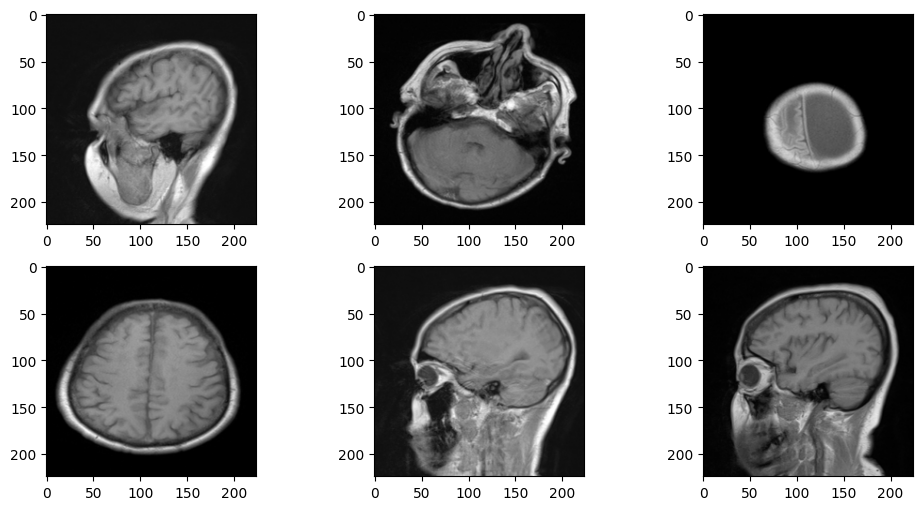

In [ ]:
fig, axis = plt.subplots(2, 3, figsize=(12, 6))
for i, batch in enumerate(train_loader):
  axis[0, 0].imshow(np.array(batch[0][0]).transpose(1, 2, 0))
  axis[0, 1].imshow(np.array(batch[0][1]).transpose(1, 2, 0))
  axis[0, 2].imshow(np.array(batch[0][2]).transpose(1, 2, 0))
  axis[1, 0].imshow(np.array(batch[0][-3]).transpose(1, 2, 0),)
  axis[1, 1].imshow(np.array(batch[0][-2]).transpose(1, 2, 0),)
  axis[1, 2].imshow(np.array(batch[0][-1]).transpose(1, 2, 0),)
  break

# 2) Model Initialization and Structure Modification


## 2.1) ResNet50: 10

Load ResNet50 model with its pretrained weights. (Suggestion: IMAGENET1K_V2)

In [ ]:
############## To Do ##############
resnet_model = ...
###################################

# Print the structure of the loaded model
print(resnet_model)

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [ ]:
############## To Do ##############
# Your code ...
###################################

# Print the structure of the modified model and notice the difference
print(resnet_model)

In [ ]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet_model = resnet_model.to(device)

## 2.2) VGG16: 10

Load VGG16 model with its pretrained parameters. (Suggestion: IMAGENET1K_V1)

In [ ]:
############## To Do ##############
vgg_model = ...
###################################

# Print the structure of the loaded model
print(vgg_model)

**Question:** Which part of this model is mainly used for classification? What kind of layer(s) are in this part? How many outputs does this model have? Why

Modify the classification part of the model so that it become suitable for your classification task, i.e. the number of outputs of the model becomes equal to number of classes in your dataset.

In [ ]:
############## To Do ##############
# Your code ...
###################################

# Print the structure of the modified model and notice the difference
print(vgg_model)

In [ ]:
# Specify the device (Suggestion: GPU is by far better than CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg_model = vgg_model.to(device)

# 3) Train Function: 15

Define your loss function for multi class classification. Don't forget to add class weights to it.

In [ ]:
wgts = wgts.to(device)

############## To Do ##############
criterion = ...
###################################

Here you should define your main train function.

**Note1:** Since you are going to change the data during the training procedure, your train function have to get dataloaders as input.

**Note2:** Also you don't know how many epochs you should train.
  So save the best weights according to validation loss at the end of each epoch,
  and after the end of training, load the best model.

**Note3:** Save loss and accuracy of train and validation in each epoch to plot them later.

**Note4:** The following code is an template that can help you, but any other functions that you define with the desired properties is acceptable.


In [ ]:
############## To Do ##############
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=10):
    since = time.time()

    acc_hist = { 'train': [], 'val': [] }
    loss_hist = { 'train': [], 'val': [] }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                ... # Set model to training mode
            else:
                ... # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                ... # zero the parameter gradients
                
                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    # Calculate outputs, predictions, and losses
                    # Your code ...

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # Your code ...

                # statistics
                running_loss += ... # Summation of losses
                running_corrects += ... # Summation of true classifications

            epoch_loss = ... # Average of losses. Use running_loss
            epoch_acc = ... # Accuracy. Use running_corrects

            if phase == 'val' and not(scheduler is None):
                ... # Set scheduler

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            acc_hist[phase].append(epoch_acc)
            loss_hist[phase].append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights with the stored state dictionary
    ...

    return model, acc_hist, loss_hist
###################################

# 4) Feature Extraction


In this section with just update parameters of the recently modified layer(s).

### 4.1) ResNet50

### 4.1.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [ ]:
############## To Do ##############
# Your code ...
###################################

### 4.1.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [ ]:
############## To Do ##############
resnet_optimizer = ...
###################################

lr_scheduler = None

In [ ]:
############## To Do ##############
resnet_fe, resnet_acc_fe, resnet_loss_fe = train_model(...)
###################################

### 4.2) VGG16

### 4.2.1) Freezing: 5

You should freeze all the parameters of the model except those of the new layer(s) you have just added.

**Help:** You can use `requires_grad` feature in Pytorch.

In [ ]:
############## To Do ##############
# Your code ...
###################################

### 4.2.2) Training: 5

Set optimizer such that just the parameters of the new layer(s) be updateded.

**Becareful:** Learning rate is a critical hyper parameter in this training task.

Scheduler is optional.

In [ ]:
############## To Do ##############
vgg_optimizer = ...
###################################

lr_scheduler = None

In [ ]:
############## To Do ##############
vgg_fe, vgg_acc_fe, vgg_loss_fe = train_model(...)
###################################

# 5) Fine-Tuning


In this section the whole parameters of the model are going to be updated.

## 5.1) ResNet50

### 5.1.1) Unfreezing

Unfreeze all the parameters.

In [ ]:
############## To Do ##############
# Your code ...
###################################

### 5.1.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [ ]:
############## To Do ##############
resnet_optimizer = ...

lr_scheduler = None

resnet_ft, resnet_acc_ft, resnet_loss_ft = train_model(...)
###################################

## 5.2) VGG16

### 5.2.1) Unfreezing

Unfreeze all the parameters.

In [ ]:
############## To Do ##############
# Your code ...
###################################

### 5.2.2) Train the Model: 5

Set optimizer such that all the parameters of the model be updateded.

**Becareful:** Since we are fine-tuning the model, we expect slight changes in the parameters, so learning rate should be very small in this section. You can also define different learning rates for newly modified layer(s) and the rest of the model.

Scheduler is optional.

In [ ]:
############## To Do ##############
vgg_optimizer = ....

lr_schedular = None

vgg_ft, vgg_acc_ft, vgg_loss_ft = train_model(...)
###################################

## 6) Plot Learning Curves: 5

Put the results of feature extraction and fine-tuning together and plot 2 figures for each of the models: accuracy and loss against epochs, i.e. 4 figures at all. Plot validation and train in one figure. Plot a vertical line that distinguish between feature extraction and fine-tuning epochs.

<ipython-input-49-f6b9a7ea7c3d>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  resnet_loss_fe[key], resnet_loss_ft[key] = torch.tensor(resnet_loss_fe[key]).cpu(), torch.tensor(resnet_loss_ft[key]).cpu()
<ipython-input-49-f6b9a7ea7c3d>:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vgg_loss_fe[key], vgg_loss_ft[key] = torch.tensor(vgg_loss_fe[key]).cpu(), torch.tensor(vgg_loss_ft[key]).cpu()


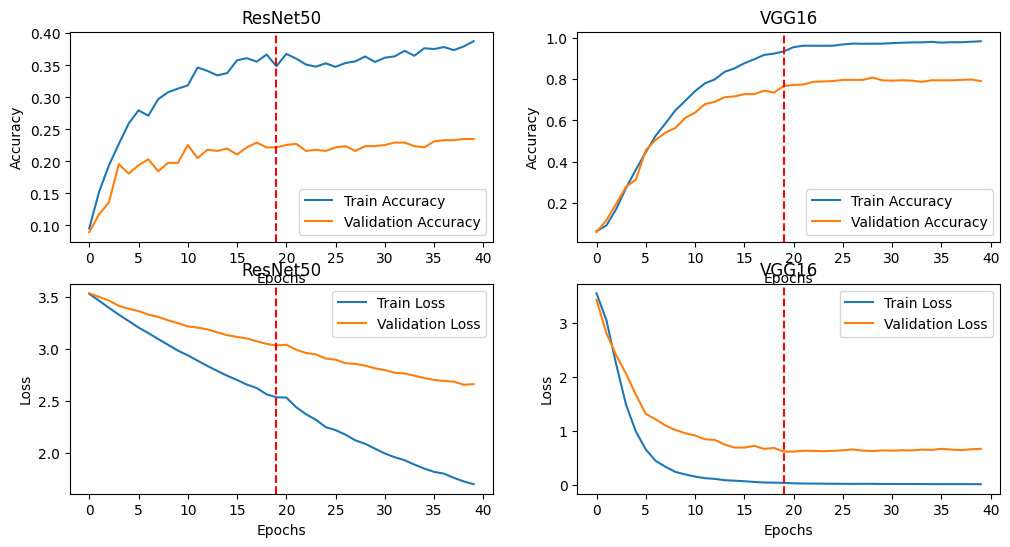

In [ ]:
############## To Do ##############
# Your code ...
###################################

## 7) Confusion Matrix: 5

Plot confusion matrix for each of the models. It should be a `num_of_classes * num_of_classes` square.

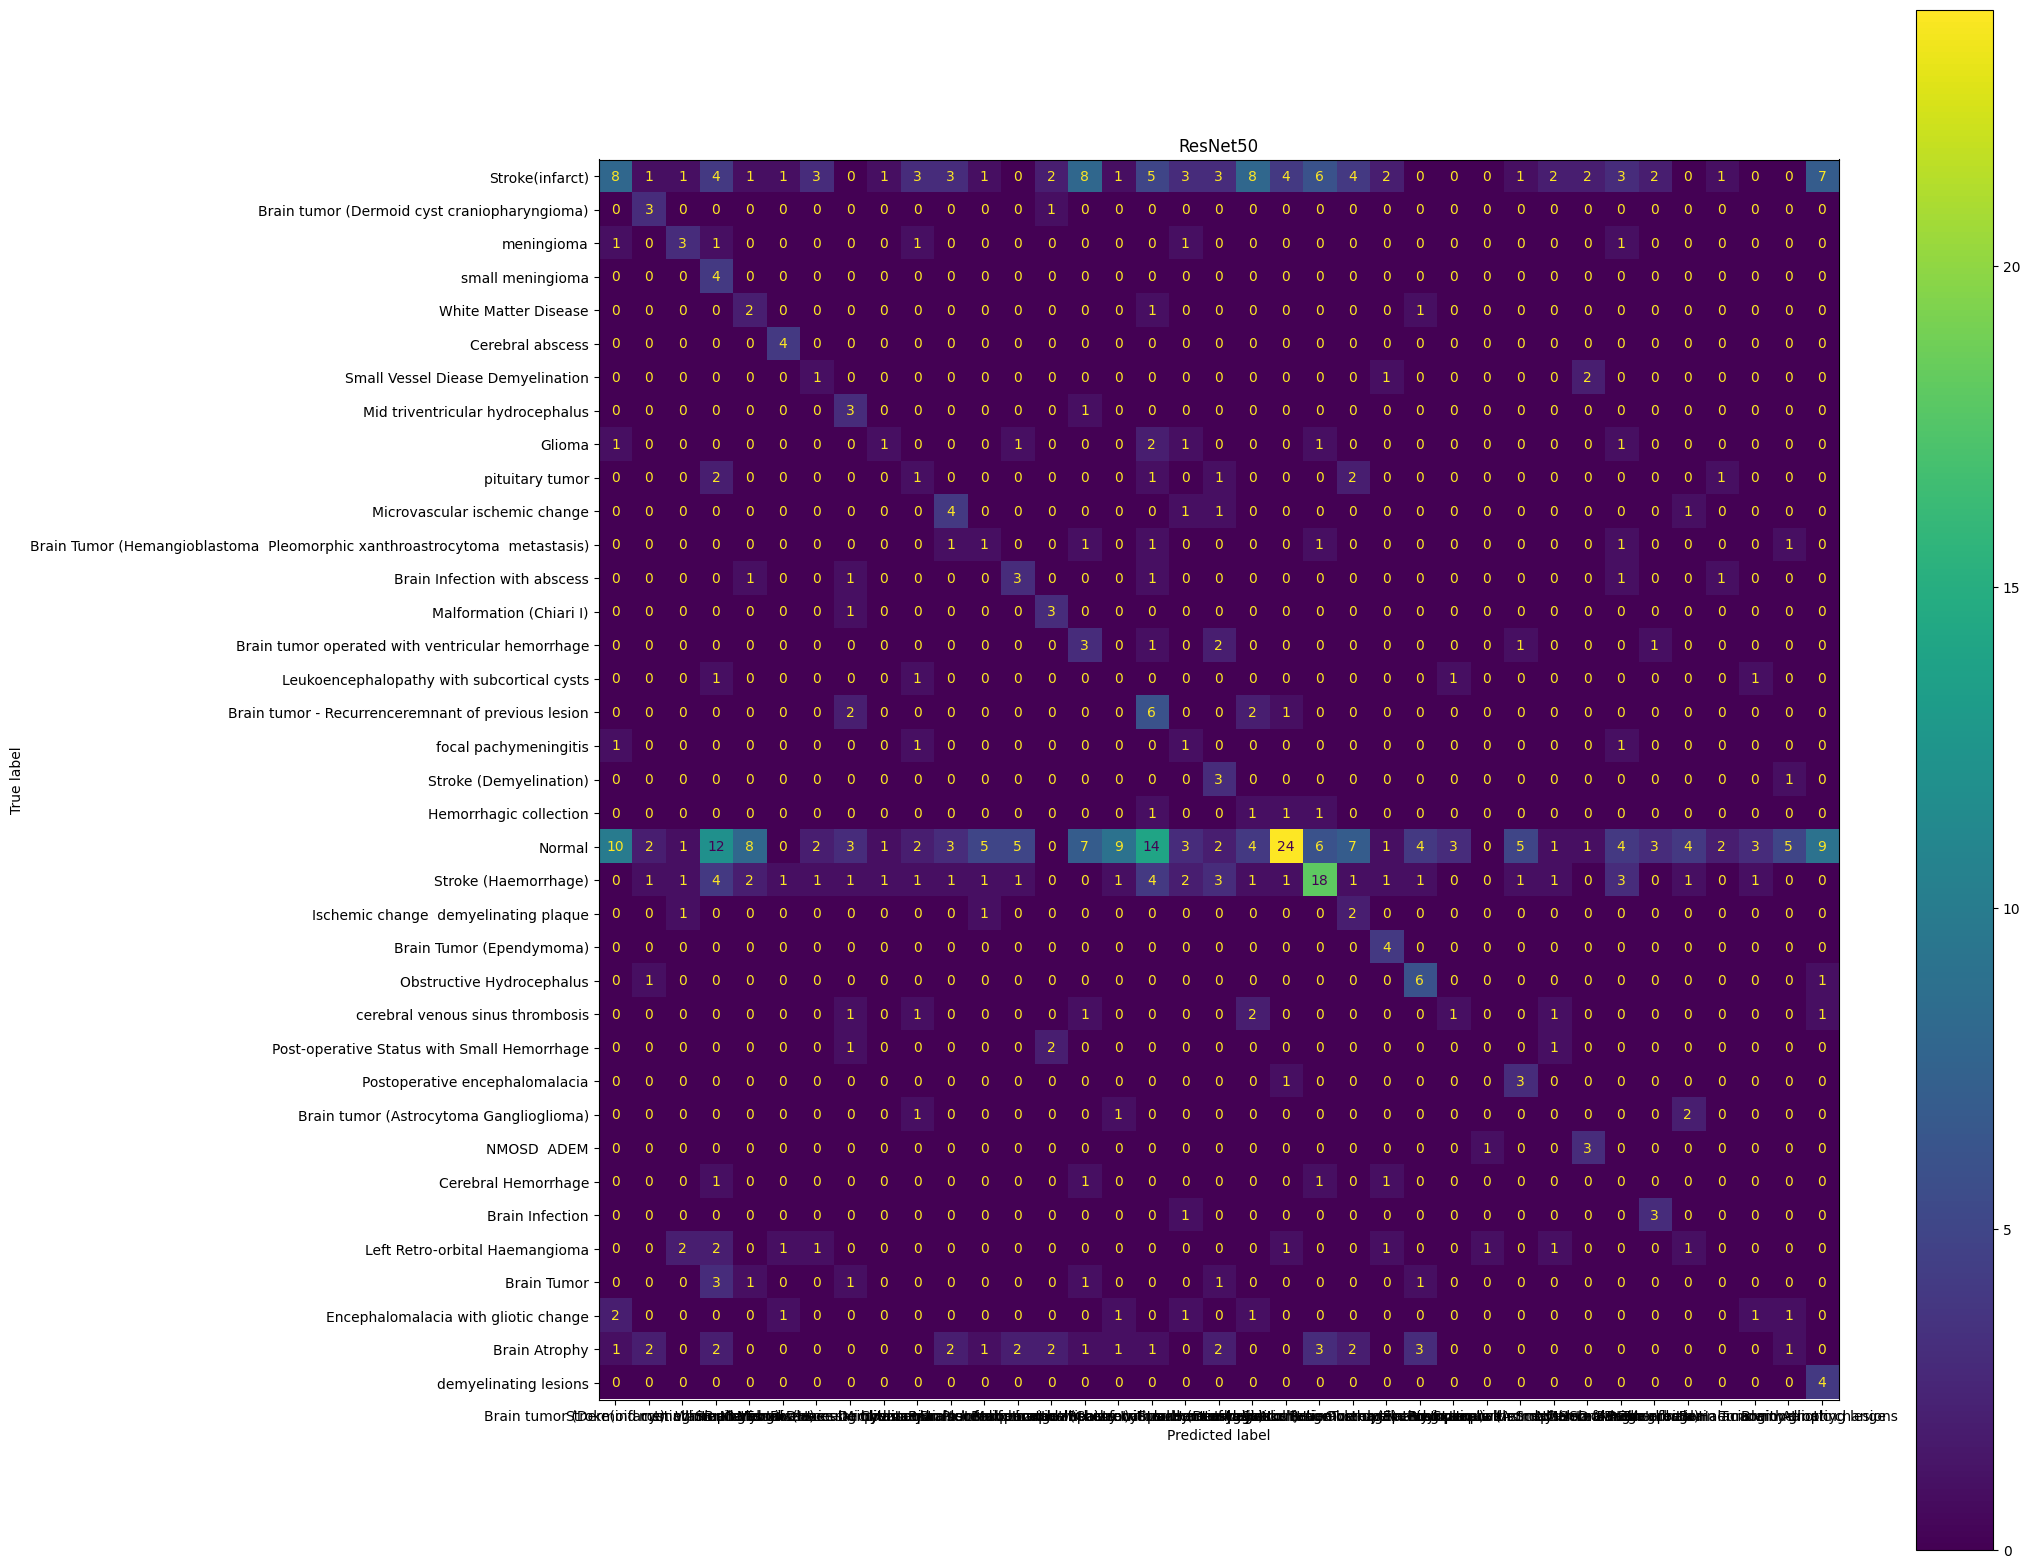

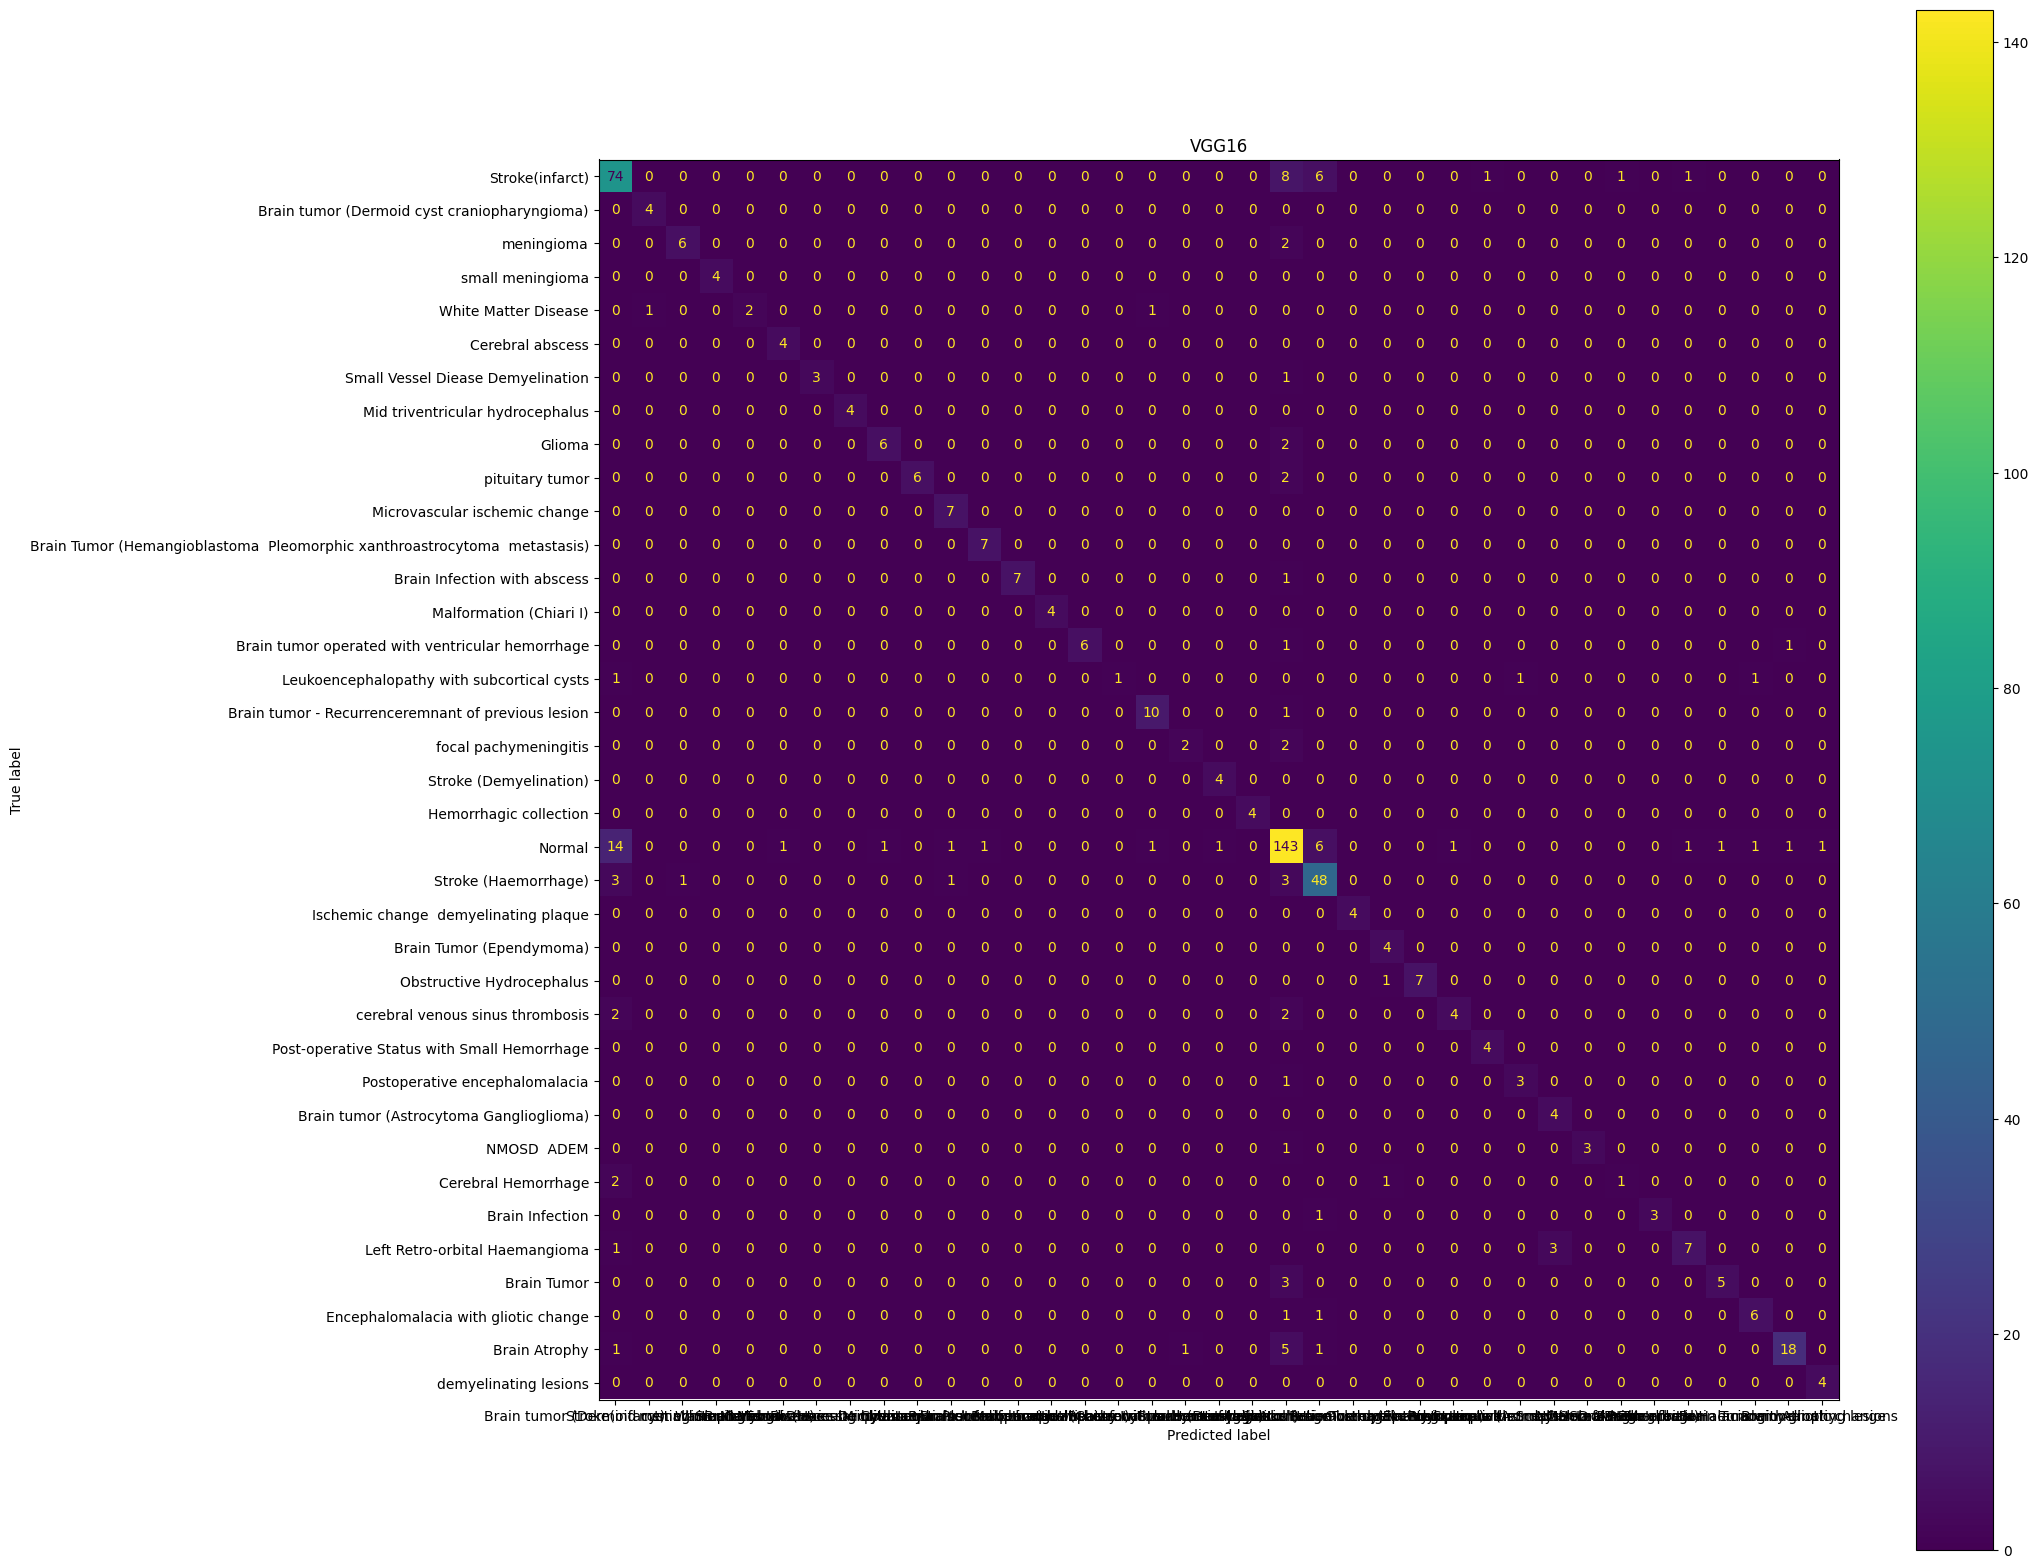

In [ ]:
############## To Do ##############
# Your code ...
###################################

# 9) Evaluate on Test Split: 10

Calculate the accuracy of each model on test data and also plot confusion matrix for both of them.

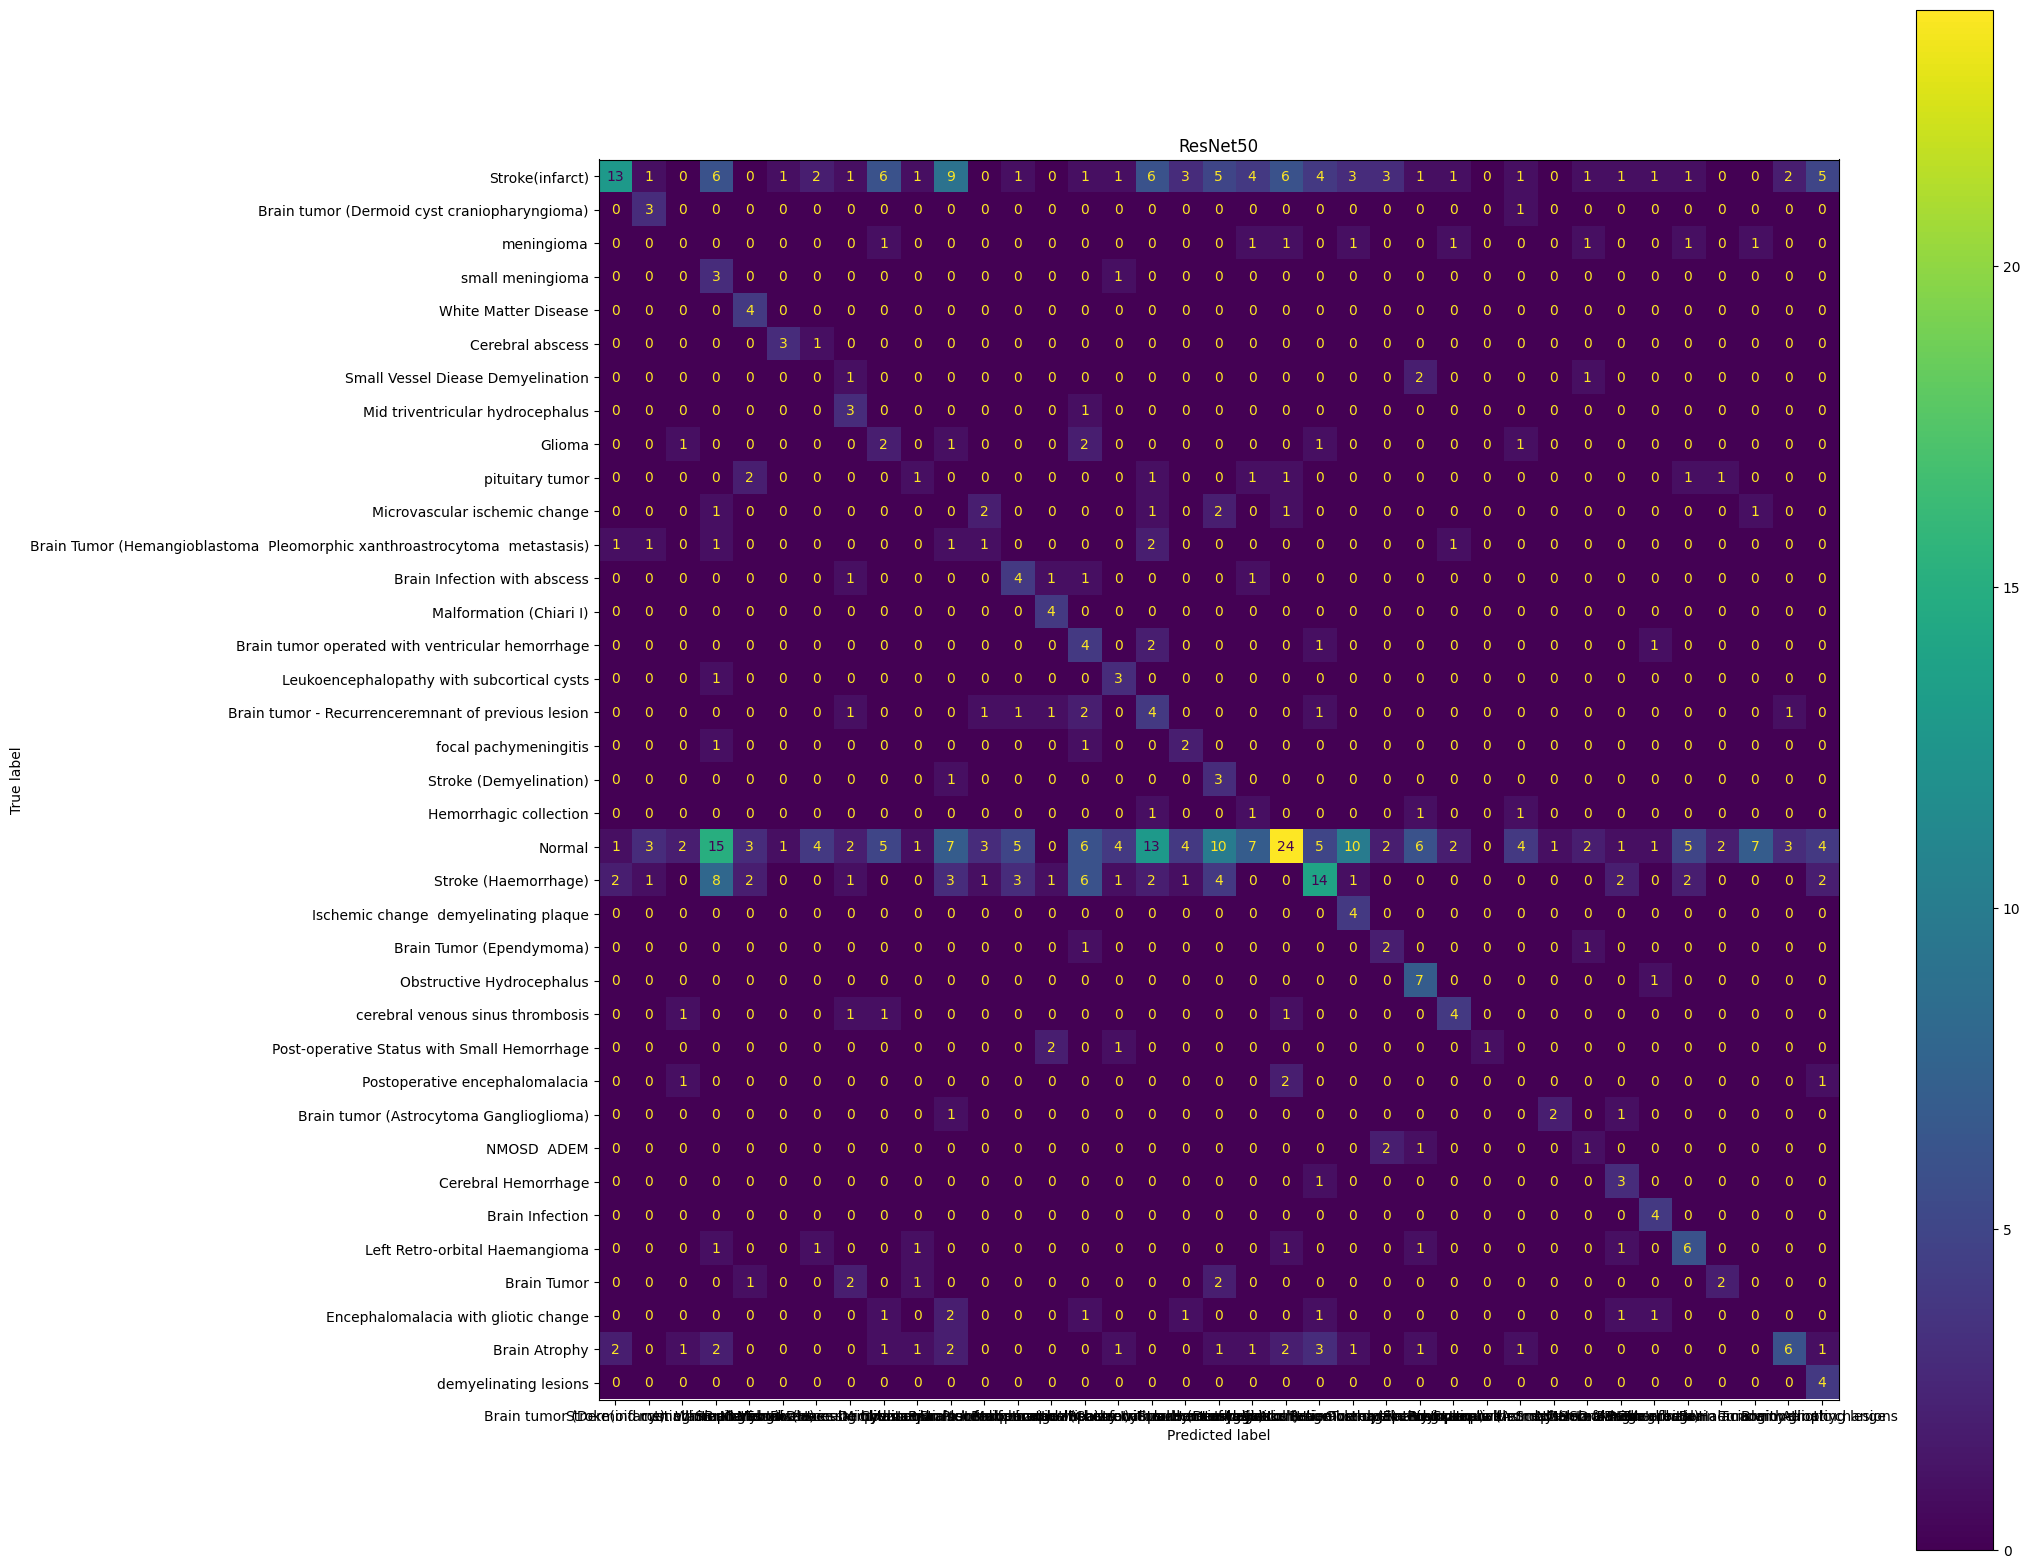

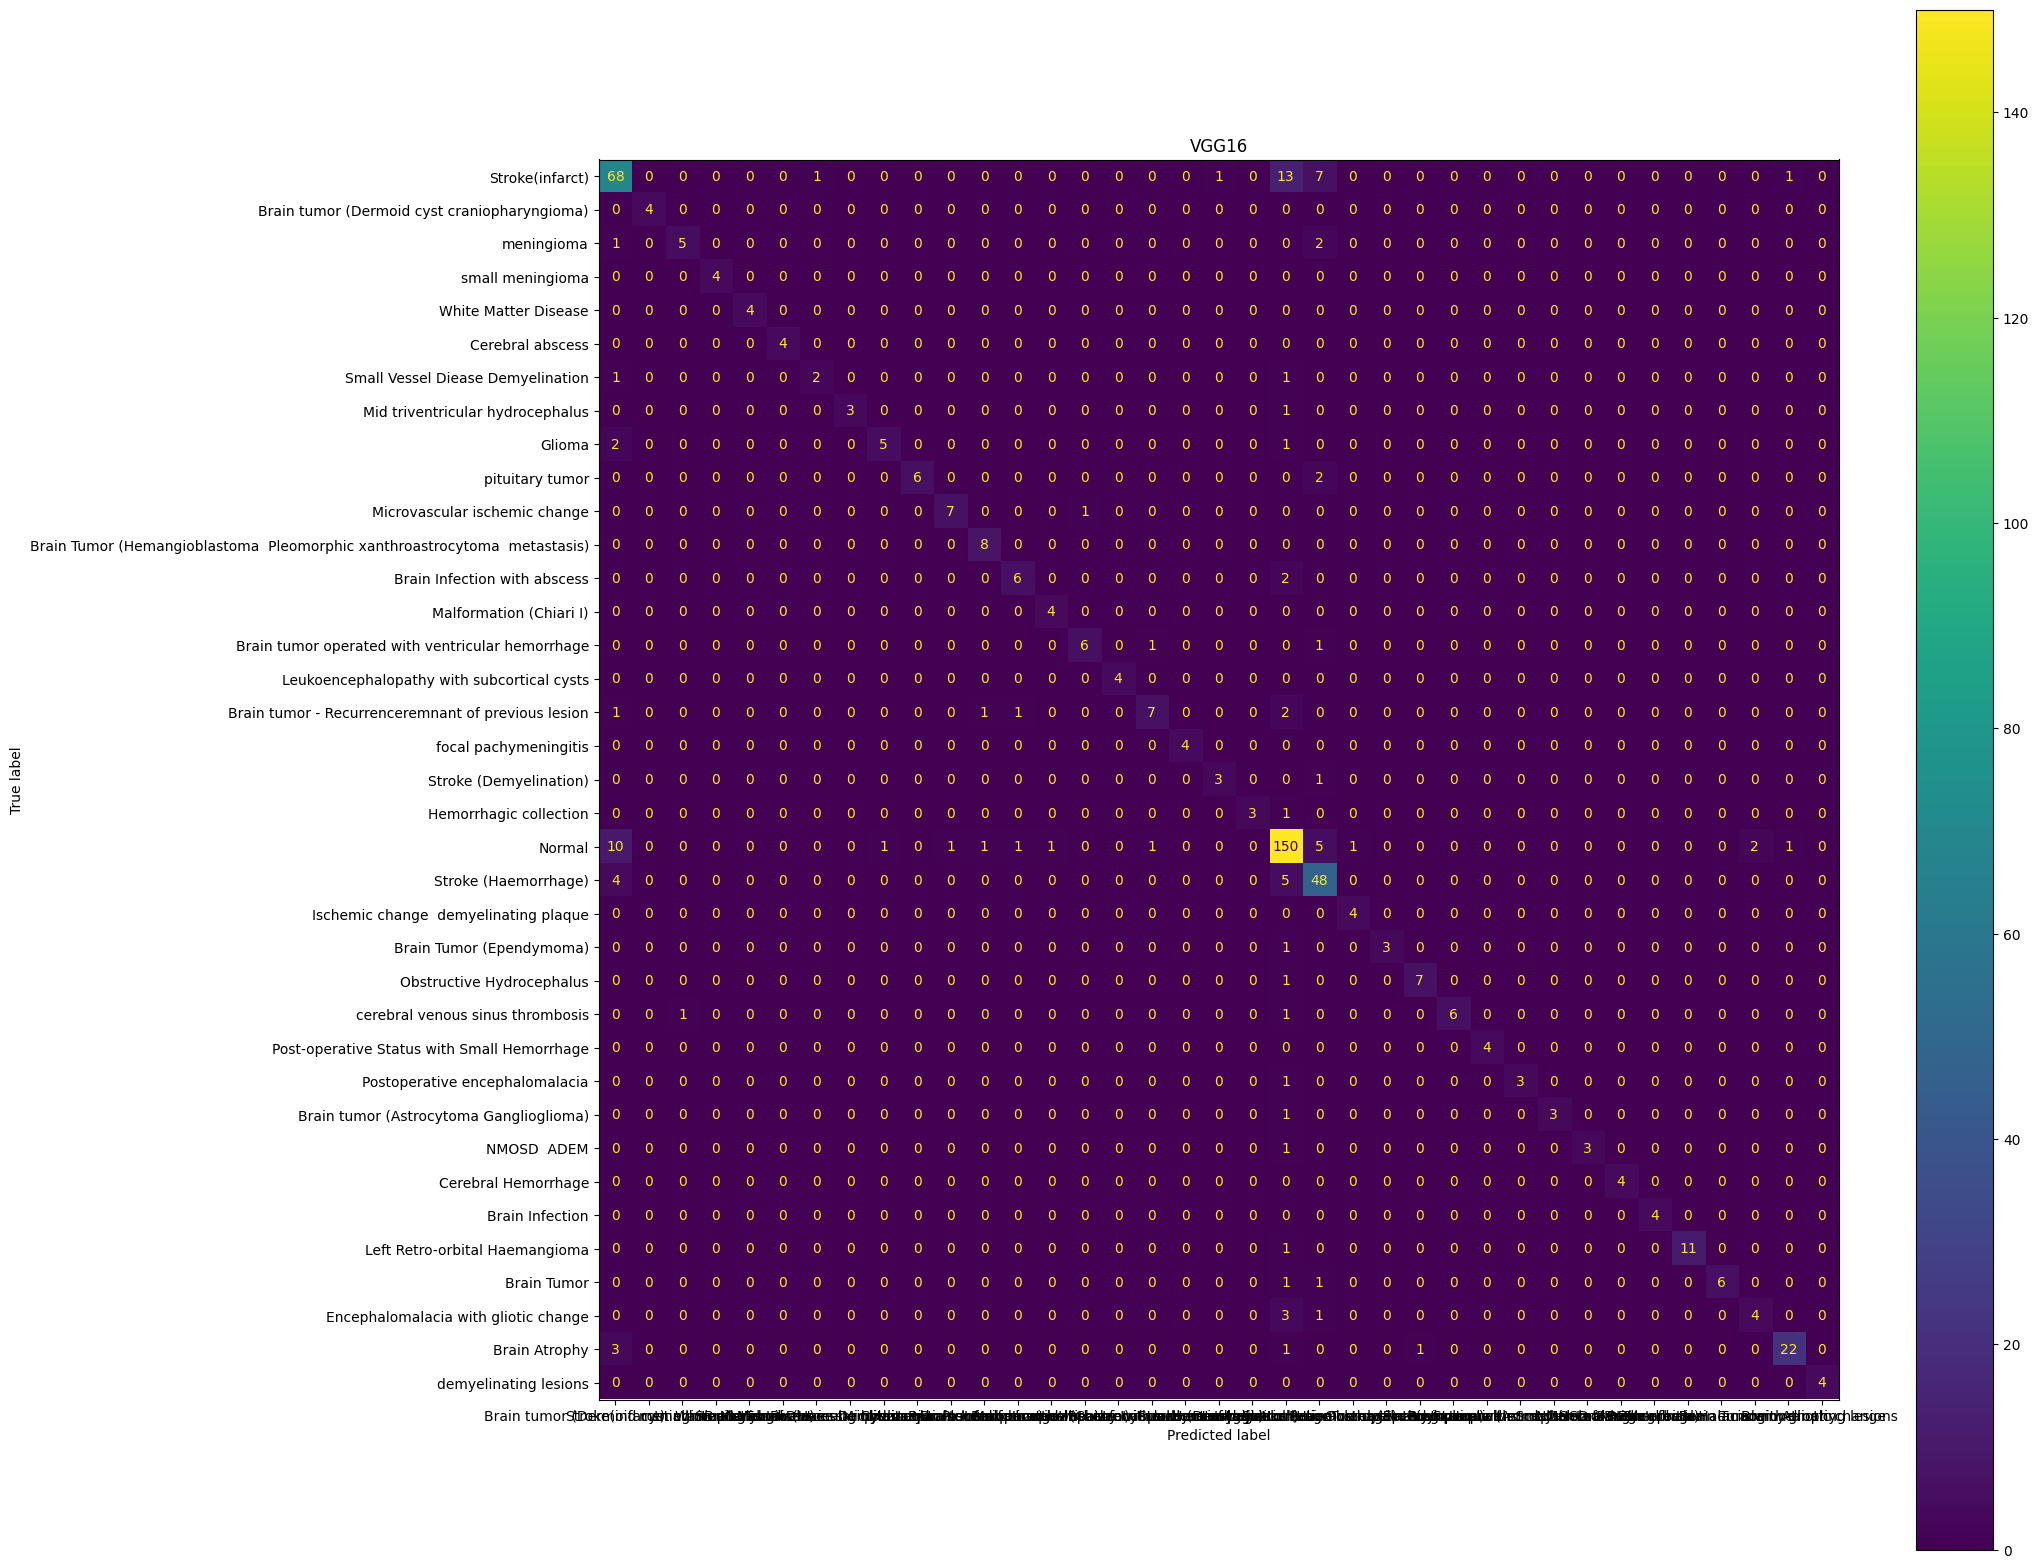

tensor(0.8173, device='cuda:0', dtype=torch.float64) tensor(0.2620, device='cuda:0', dtype=torch.float64)


In [ ]:
############## To Do ##############
# Your code ...
###################################